In [1]:
import numpy             as np
import scipy             as sp
import matplotlib.pyplot as plt
import matplotlib
import time
from numba import njit

from tqdm            import tqdm
from scipy           import signal

from propagation import received_power, quad_distribute_power, propagation_delay, map_rx_config, map_tx_config

from parametermeasurement import generate_clocks, measure_range_roberts, measure_bearing

from positioning import classicalfix_directbearing_crlb, classicalfix_diffbearing_crlb, \
                        classicalfix_directrange_crlb, classicalfix_diffrange_crlb

In [2]:
a = np.load('results/es2_testtrack_crlb_classical/crlb_classical_raindirectsun.npz')

x = a['x']
y = a['y']
est_x_directbearing = a['est_x_directbearing']
est_y_directbearing = a['est_y_directbearing']
est_x_directrange = a['est_x_directrange']
est_y_directrange = a['est_y_directrange']
est_x_diffbearing = a['est_x_diffbearing']
est_y_diffbearing = a['est_y_diffbearing']
est_x_diffrange = a['est_x_diffrange']
est_y_diffrange = a['est_y_diffrange']
d_rxL_txL = a['d_rxL_txL']
d_rxL_txR = a['d_rxL_txR']
d_rxR_txL = a['d_rxR_txL']
d_rxR_txR = a['d_rxR_txR']
aoa_rxL_txL = a['aoa_rxL_txL']
aoa_rxL_txR = a['aoa_rxL_txR']
aoa_rxR_txL = a['aoa_rxR_txL']
aoa_rxR_txR = a['aoa_rxR_txR']
deld_rxLR_txL = a['deld_rxLR_txL']
deld_rxLR_txR = a['deld_rxLR_txR']
delaoa_rxLR_txL = a['delaoa_rxLR_txL']
delaoa_rxLR_txR = a['delaoa_rxLR_txR']

L = 1.6

In [3]:
sz = 20;
crlb_x_directbearing = np.zeros((sz)); crlb_y_directbearing = np.zeros((sz))
crlb_x_diffbearing   = np.zeros((sz)); crlb_y_diffbearing   = np.zeros((sz))
crlb_x_directrange   = np.zeros((sz)); crlb_y_directrange   = np.zeros((sz))
crlb_x_diffrange     = np.zeros((sz)); crlb_y_diffrange     = np.zeros((sz))

e_dLL = np.sqrt(x**2 +y**2) - d_rxL_txL
e_dRL = np.sqrt((x-L)**2 +y**2) - d_rxR_txL
e_dLR = np.sqrt((x+L)**2 +y**2) - d_rxL_txR
e_dRR = np.sqrt((x+L-L)**2 +y**2) - d_rxR_txR

e_deld_L = (np.sqrt(x**2 +y**2) - np.sqrt((x-L)**2 +y**2)) - deld_rxLR_txL
e_deld_R = (np.sqrt((x+L)**2 +y**2) - np.sqrt((x+L-L)**2 +y**2)) - deld_rxLR_txR

e_aLL = np.rad2deg(np.arctan2(x,y)) - aoa_rxL_txL
e_aRL = np.rad2deg(np.arctan2(x-L,y)) - aoa_rxR_txL
e_aLR = np.rad2deg(np.arctan2(x+L,y)) - aoa_rxL_txR
e_aRR = np.rad2deg(np.arctan2(x+L-L,y)) - aoa_rxR_txR

e_dela_L = (np.rad2deg(np.arctan2(x,y)) - np.rad2deg(np.arctan2(x-L,y))) - delaoa_rxLR_txL
e_dela_R = (np.rad2deg(np.arctan2(x+L,y)) - np.rad2deg(np.arctan2(x+L-L,y))) - delaoa_rxLR_txR

e_db_x  = x - est_x_directbearing
e_db_y  = y - est_y_directbearing
e_fb_x  = x - est_x_diffbearing
e_fb_y  = y - est_y_diffbearing
e_dr_x  = x - est_x_directrange
e_dr_y  = y - est_y_directrange
e_fr_x  = x - est_x_diffrange
e_fr_y  = y - est_y_diffrange

for i in range(0, y.shape[0]):
    crlb_x_directbearing[i], crlb_y_directbearing[i] = classicalfix_directbearing_crlb( np.std(np.deg2rad(e_aLL[:,i]), axis=0), np.std(np.deg2rad(e_aRL[:,i]), axis=0), x[i], y[i], L) 
    crlb_x_diffbearing[i], crlb_y_diffbearing[i]     = classicalfix_diffbearing_crlb( np.std(np.deg2rad(e_dela_L[:,i]), axis=0), np.std(np.deg2rad(e_dela_R[:,i]), axis=0), x[i], y[i], L) 
    crlb_x_directrange[i], crlb_y_directrange[i]     = classicalfix_directrange_crlb(np.std(e_dLL[:,i], axis=0), np.std(e_dRL[:,i], axis=0), x[i], y[i], L) 
    crlb_x_diffrange[i], crlb_y_diffrange[i]         = classicalfix_diffrange_crlb(np.std(e_deld_L[:,i], axis=0), np.std(e_deld_R[:,i], axis=0), x[i], y[i], L) 

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

(0.0001, 10.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


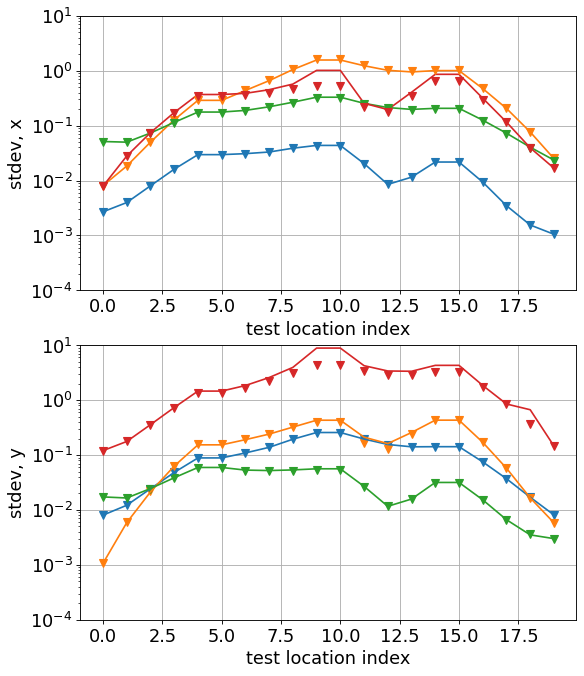

In [5]:
fig, ax = plt.subplots(2,1, figsize=(8, 10), dpi=80)
ax[0].semilogy(np.std(e_db_x, axis=0),'-C0')
ax[0].semilogy(np.std(e_fb_x, axis=0),'-C1')
ax[0].semilogy(np.std(e_dr_x, axis=0),'-C2')
ax[0].semilogy(np.std(e_fr_x, axis=0),'-C3')
ax[0].semilogy(np.sqrt(crlb_x_directbearing),'vC0', markersize=8)
ax[0].semilogy(np.sqrt(crlb_x_diffbearing),'vC1', markersize=8)
ax[0].semilogy(np.sqrt(crlb_x_directrange),'vC2', markersize=8)
ax[0].semilogy(np.sqrt(crlb_x_diffrange),'vC3', markersize=8)
ax[0].set_ylabel('stdev, x')
ax[0].set_xlabel('test location index')
ax[0].grid()
ax[0].set_ylim([1e-4, 1e1])
#ax[0].legend(['direct bearing (DB)','diff. bearing (FB)','direct range (DR)','diff. range (FR)'], ncol=2)
ax[1].semilogy(np.sqrt(crlb_y_directbearing),'vC0', markersize=8)
ax[1].semilogy(np.sqrt(crlb_y_diffbearing),'vC1', markersize=8)
ax[1].semilogy(np.sqrt(crlb_y_directrange),'vC2', markersize=8)
ax[1].semilogy(np.sqrt(crlb_y_diffrange),'vC3', markersize=8)
ax[1].semilogy(np.std(e_db_y, axis=0),'-C0')
ax[1].semilogy(np.std(e_fb_y, axis=0),'-C1')
ax[1].semilogy(np.std(e_dr_y, axis=0),'-C2')
ax[1].semilogy(np.std(e_fr_y, axis=0),'-C3')
ax[1].set_ylabel('stdev, y')
ax[1].set_xlabel('test location index')
ax[1].grid()
ax[1].set_ylim([1e-4, 1e1])
#ax[1].legend(['DB CRLB','FB CRLB','DR CRLB','FR CRLB'], ncol=2)
#plt.savefig('ES2_raindirectsun.jpg')

(1e-05, 100.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


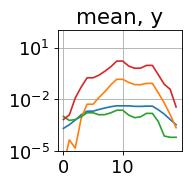

In [6]:
fig, ax = plt.subplots(1,1, figsize=(2, 2), dpi=80)
ax.semilogy(np.abs(np.mean(e_db_y, axis=0)),'-C0')
ax.semilogy(np.abs(np.mean(e_fb_y, axis=0)),'-C1')
ax.semilogy(np.abs(np.mean(e_dr_y, axis=0)),'-C2')
ax.semilogy(np.abs(np.mean(e_fr_y, axis=0)),'-C3')
ax.set_title('mean, y')
ax.grid()
ax.set_ylim([1e-5, 1e2])
#plt.savefig('means.jpg', bbox_inches="tight")

Text(0, 0.5, 'longitudinal [m]')

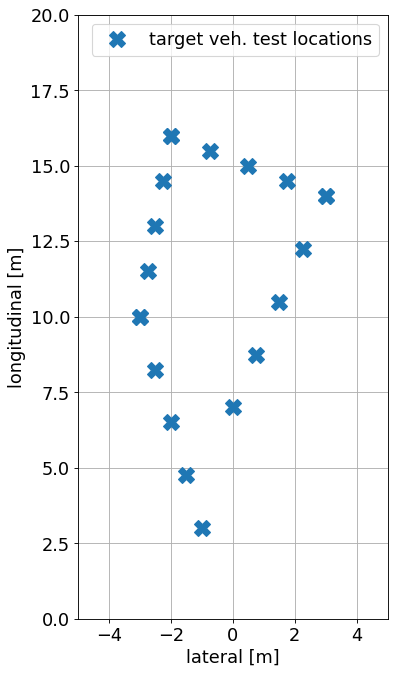

In [7]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.plot(x, y, 'X', markersize=15)
#ax.plot(np.mean(est_x_directbearing,axis=0), np.mean(est_y_directbearing,axis=0),'-oC0')
#ax.plot(np.mean(est_x_diffbearing,axis=0), np.mean(est_y_diffbearing,axis=0),'-vC1')
#ax.plot(np.mean(est_x_directrange,axis=0), np.mean(est_y_directrange,axis=0),'-^C2')
#ax.plot(np.mean(est_x_diffrange,axis=0), np.mean(est_y_diffrange,axis=0),'-sC3')
plt.xlim([-5,5])
plt.ylim([0,20])
ax.grid()
ax.legend(['target veh. test locations'])
plt.xlabel('lateral [m]')
plt.ylabel('longitudinal [m]')
#plt.savefig('crlb_track.jpg', bbox_inches="tight")